# Larval fish dispersal simulation using Ocean Parcels (http://www.oceanparcels.org)
#### Analyis conducted using BRAN2020 model. Full data catalogue available at: 
- https://dapds00.nci.org.au/thredds/catalog/gb6/BRAN/BRAN2020/catalog.html 

#### References used for this notebook: 
- https://gist.github.com/mrayson/28cc2fa25eb3ea59b2885e651c587dd2 
- https://tristansalles.github.io/EnviReef/6-addson/parcels.html
- https://oceanparcels.org/#tutorials

<div class="alert alert-block alert-info">
<b>Step One:</b> Open BRAN2020 netCDF files and crop to make data managable.
</div>

Install python libraries

In [2]:
import os
import numpy as np
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset, num2date
import datetime as dt

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
from datetime import timedelta
from operator import attrgetter

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

#Comment out the below if needed
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

Specify time period and load BRAN2020 data source

In [3]:
month = 1   # Month
year = 2022    # Year

Load BRAN2020 data source

In [ ]:
netCDF_datestr = str(year)+'_'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

# U and V Current files ('U': 'eastward_eulerian_current_velocity', 'V': 'northward_eulerian_current_velocity')
u_files = "https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_u_"+netCDF_datestr+".nc"
v_files = "https://dapds00.nci.org.au/thredds/dodsC/gb6/BRAN/BRAN2020/daily/ocean_v_"+netCDF_datestr+".nc"

Specify geographic range of data

In [4]:
min_lon = 148.
min_lat = -48.
max_lat = -17.
max_lon = 160.

Create netCDF files for each month: 1) crop dataset to desired geographic range, 2) drop unnessecary variables from dataset and 3) crop data to depth within photic zone

In [ ]:
# U Current file trim
ds_u = xr.open_dataset(u_files, chunks='auto', 
                                 drop_variables=['Time_bounds', 'average_DT', 'average_T1' , 
                                                 'average_T2', 'st_edges_ocean', 'nv'])
mask_lon = (ds_u.xu_ocean >= min_lon) & (ds_u.xu_ocean <= max_lon)
mask_lat = (ds_u.yu_ocean >= min_lat) & (ds_u.yu_ocean <= max_lat)
cropped_ds_u = ds_u.where(mask_lon & mask_lat, drop=True)
photicZone = cropped_ds_u.isel(st_ocean= slice(0,3))
    
photicZone.to_netcdf('photicZone_Current_u'+str(month)+'_'+str(year)+'.nc')

In [ ]:
# V Current file trim
ds_v = xr.open_dataset(v_files, chunks='auto', 
                                 drop_variables=['Time_bounds', 'average_DT', 'average_T1' , 
                                                 'average_T2', 'st_edges_ocean', 'nv'])
mask_lon = (ds_v.xu_ocean >= min_lon) & (ds_v.xu_ocean <= max_lon)
mask_lat = (ds_v.yu_ocean >= min_lat) & (ds_v.yu_ocean <= max_lat)
cropped_ds_v = ds_v.where(mask_lon & mask_lat, drop=True)
photicZone = cropped_ds_v.isel(st_ocean= slice(0,3))
    
photicZone.to_netcdf('photicZone_Current_v'+str(month)+'_'+str(year)+'.nc')

<div class="alert alert-block alert-info">
<b>Step Two:</b> Combine 'U' and 'V' current files and calculate the velocity (speed).
</div>

Open the cropped 'U' and 'V' current files

In [ ]:
ds_u = xr.open_dataset('photicZone_Current_u'+str(month)+'_'+str(year)+'.nc')
ds_v = xr.open_dataset('photicZone_Current_v'+str(month)+'_'+str(year)+'.nc')

Subset an xarray.DataArray

In [ ]:
my_u = ds_u['u'].sel(st_ocean=7.5)
my_v = ds_v['v'].sel(st_ocean=7.5)

Calculate the current velocity as 'speed'

In [ ]:
speed = np.abs(my_u + 1j*my_v)

In [ ]:
%%time
# (this will actually download the data)
speed = speed.compute()

In [ ]:
out_ds = xr.DataArray({'u':my_u,'v':my_v, 'speed':speed})

In [ ]:
out_ds = xr.Dataset({'u':my_u,'v':my_v, 'speed':speed})

Save as a new combined NetCDF file, containing 'U' and 'V' current and speed

In [ ]:
out_ds.to_netcdf('Current_speed_UandV_'+str(month)+'_'+''+str(year)+'.nc')

<div class="alert alert-block alert-info">
<b>Step Three:</b> Run the Ocean Pacels particle simulation.
</div>

Open the combined 'U' and 'V' current and speed netCDF

In [5]:
netCDF_datestr = str(year)+'_'+format(month, '02')
print('File chosen time interval:',netCDF_datestr)

data_name = "Current_speed_UandV_"+netCDF_datestr+".nc"

File chosen time interval: 2022_01


Check visual for data completeness

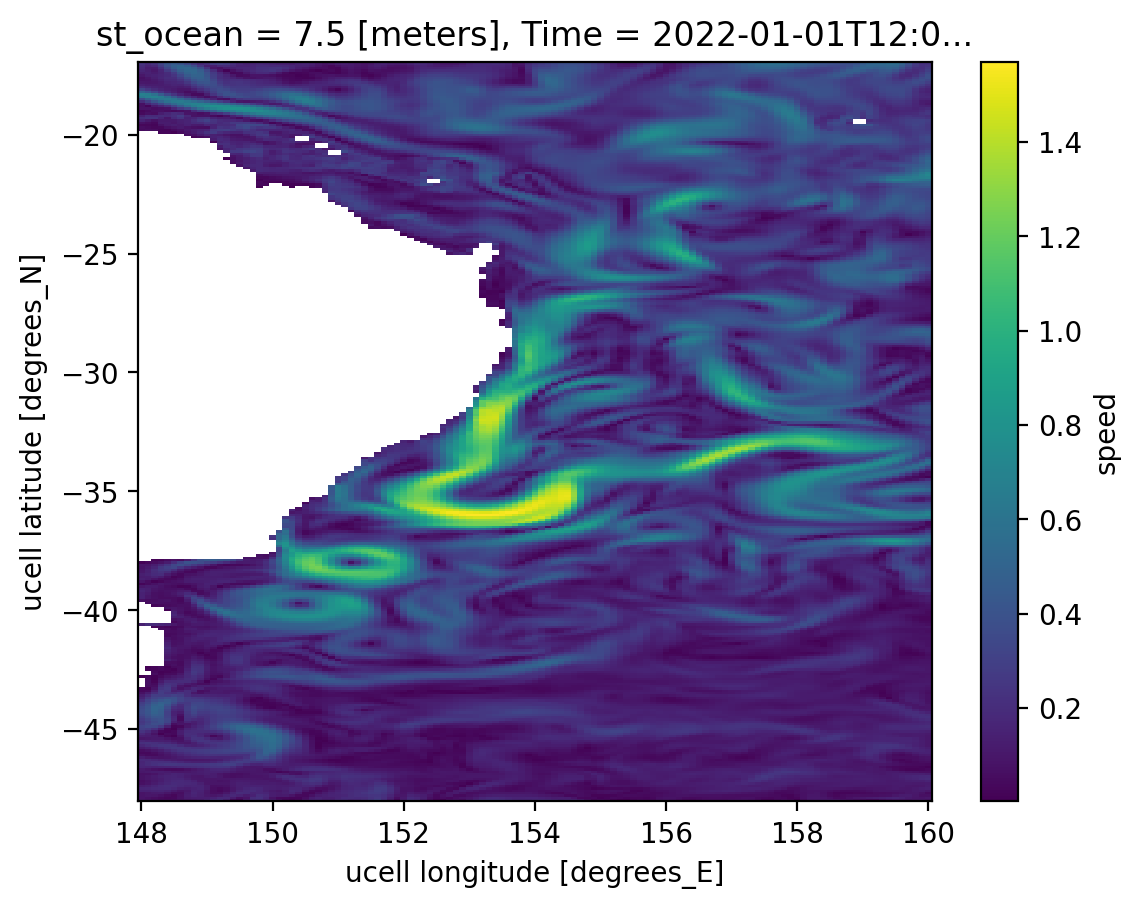

In [6]:
ds = xr.open_dataset(data_name)
ds.isel(Time=0).speed.plot()

Create a data file structure for our variables

In [7]:
filenames = {'U': data_name,
             'V': data_name,
            }

variables = {'U': 'u',
             'V': 'v'}

dimensions = {'lat': 'yu_ocean',
              'lon': 'xu_ocean',
              'time': 'Time'}

From parcels import FieldSet 

In [8]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)

Create a function to remove particles that go 'out of bounds' from the defined lat/lon range.


In [9]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

Define a new particle class that contains three extra variables

In [10]:
class DistParticle(JITParticle):
    
    distance = Variable('distance', initial=0., dtype=np.float32)  # the distance travelled
    prev_lon = Variable('prev_lon', dtype=np.float32, to_write=False,
                        initial=attrgetter('lon'))  # the previous longitude
    prev_lat = Variable('prev_lat', dtype=np.float32, to_write=False,
                        initial=attrgetter('lat'))  # the previous latitude.

In [11]:
def TotalDistance(particle, fieldset, time):
    
    # Calculate the distance in latitudinal direction (using 1.11e2 kilometer per degree latitude)
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    # Calculate the distance in longitudinal direction, using cosine(latitude) - spherical earth
    lon_dist = (particle.lon - particle.prev_lon) * 1.11e2 * math.cos(particle.lat * math.pi / 180)
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    particle.prev_lon = particle.lon  # Set the stored values for next iteration.
    particle.prev_lat = particle.lat

Simulate particle release from pre-defined locations and depth

In [12]:
pset = ParticleSet.from_list(fieldset=fieldset, 
                             pclass=DistParticle,
                             #Location points chosed near Capricorn group, Great Barrier Reef, Red Rocks, Nambucca and South West Rocks.
                             lon=[148., 150., 153., 153., 151., 153., 155., 155., 156., 158.],
                             lat=[-21.,-21., -21., -24., -23., -30.5,-21., -30.5, -21., -21.],
                             depth=[7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5])
                        

Create and save the model output

In [13]:
output_zarr_dist = 'CurrentParticlesDist_'+str(year)+'_'+format(month, '02')+'.zarr'
try:
    os.remove(output_zarr_dist)
except OSError:
    pass

file_dist = pset.ParticleFile(name=output_zarr_dist, 
                                outputdt=timedelta(hours=1))

k_dist = pset.Kernel(TotalDistance)  # Casting the TotalDistance function to a kernel.

pset.execute(AdvectionRK4 + k_dist,  # Add kernels using the + operator.
             runtime=timedelta(days=30),
             dt=timedelta(minutes=5),
             output_file=file_dist,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})


INFO: Compiled ArrayDistParticleAdvectionRK4TotalDistance ==> /tmp/parcels-140719/liba6b80a724df39bb3b9380fe2b2ced089_0.so
INFO: Output files are stored in CurrentParticlesDist_2022_01.zarr.
100%|██████████| 2592000.0/2592000.0 [11:28<00:00, 3764.57it/s]


Print the distance in km that each particle has travelled

In [14]:
print([p.distance for p in pset])

[0.0, 268.02005, 1605.6906, 533.9165, 0.0, 0.0, 485.67172, 644.4159, 447.37213, 681.6886]


In [15]:
print(pset)

P[0](lon=148.000000, lat=-21.000000, depth=7.500000, distance=0.000000, time=2592000.000000)
P[1](lon=151.328384, lat=-22.132751, depth=7.500000, distance=268.020050, time=2592000.000000)
P[2](lon=151.870682, lat=-34.293606, depth=7.500000, distance=1605.690552, time=2592000.000000)
P[3](lon=153.780182, lat=-26.560030, depth=7.500000, distance=533.916504, time=2592000.000000)
P[4](lon=151.000000, lat=-23.000000, depth=7.500000, distance=0.000000, time=2592000.000000)
P[5](lon=153.000000, lat=-30.500000, depth=7.500000, distance=0.000000, time=2592000.000000)
P[6](lon=157.778259, lat=-20.766005, depth=7.500000, distance=485.671722, time=2592000.000000)
P[7](lon=152.522751, lat=-34.308060, depth=7.500000, distance=644.415894, time=2592000.000000)
P[8](lon=153.778793, lat=-22.231718, depth=7.500000, distance=447.372131, time=2592000.000000)
P[9](lon=155.924835, lat=-19.517328, depth=7.500000, distance=681.688599, time=2592000.000000)


Open the particle simulation output

In [16]:
parcels_dist = xr.open_dataset(output_zarr_dist)
parcels_dist

<xarray.Dataset>
Dimensions:     (trajectory: 10, obs: 721)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719 720
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    distance    (trajectory, obs) float32 ...
    lat         (trajectory, obs) float32 ...
    lon         (trajectory, obs) float32 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float32 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.1.dev9

Open the ocean current file (i.e. U, V and speed data) for use in final plot

In [17]:
ds_hydro = xr.open_dataset(data_name)
ds_hydro

<xarray.Dataset>
Dimensions:   (xu_ocean: 121, yu_ocean: 311, Time: 31)
Coordinates:
  * xu_ocean  (xu_ocean) float64 148.0 148.1 148.2 148.3 ... 159.8 159.9 160.0
  * yu_ocean  (yu_ocean) float64 -48.0 -47.9 -47.8 -47.7 ... -17.2 -17.1 -17.0
    st_ocean  float64 ...
  * Time      (Time) datetime64[ns] 2022-01-01T12:00:00 ... 2022-01-31T12:00:00
Data variables:
    u         (Time, yu_ocean, xu_ocean) float32 ...
    v         (Time, yu_ocean, xu_ocean) float32 ...
    speed     (Time, yu_ocean, xu_ocean) float32 ...

Import the custom marker package

In [18]:
import matplotlib as mpl
!pip install svgpath2mpl
!pip install svgpathtools

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Create a custom 'fish' maker

In [19]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

fish_path, attributes = svg2paths('solidfish.svg')
fish_marker = parse_path(attributes[0]['d'])

Create our final simulation map

/tmp/ipykernel_308/63224090.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


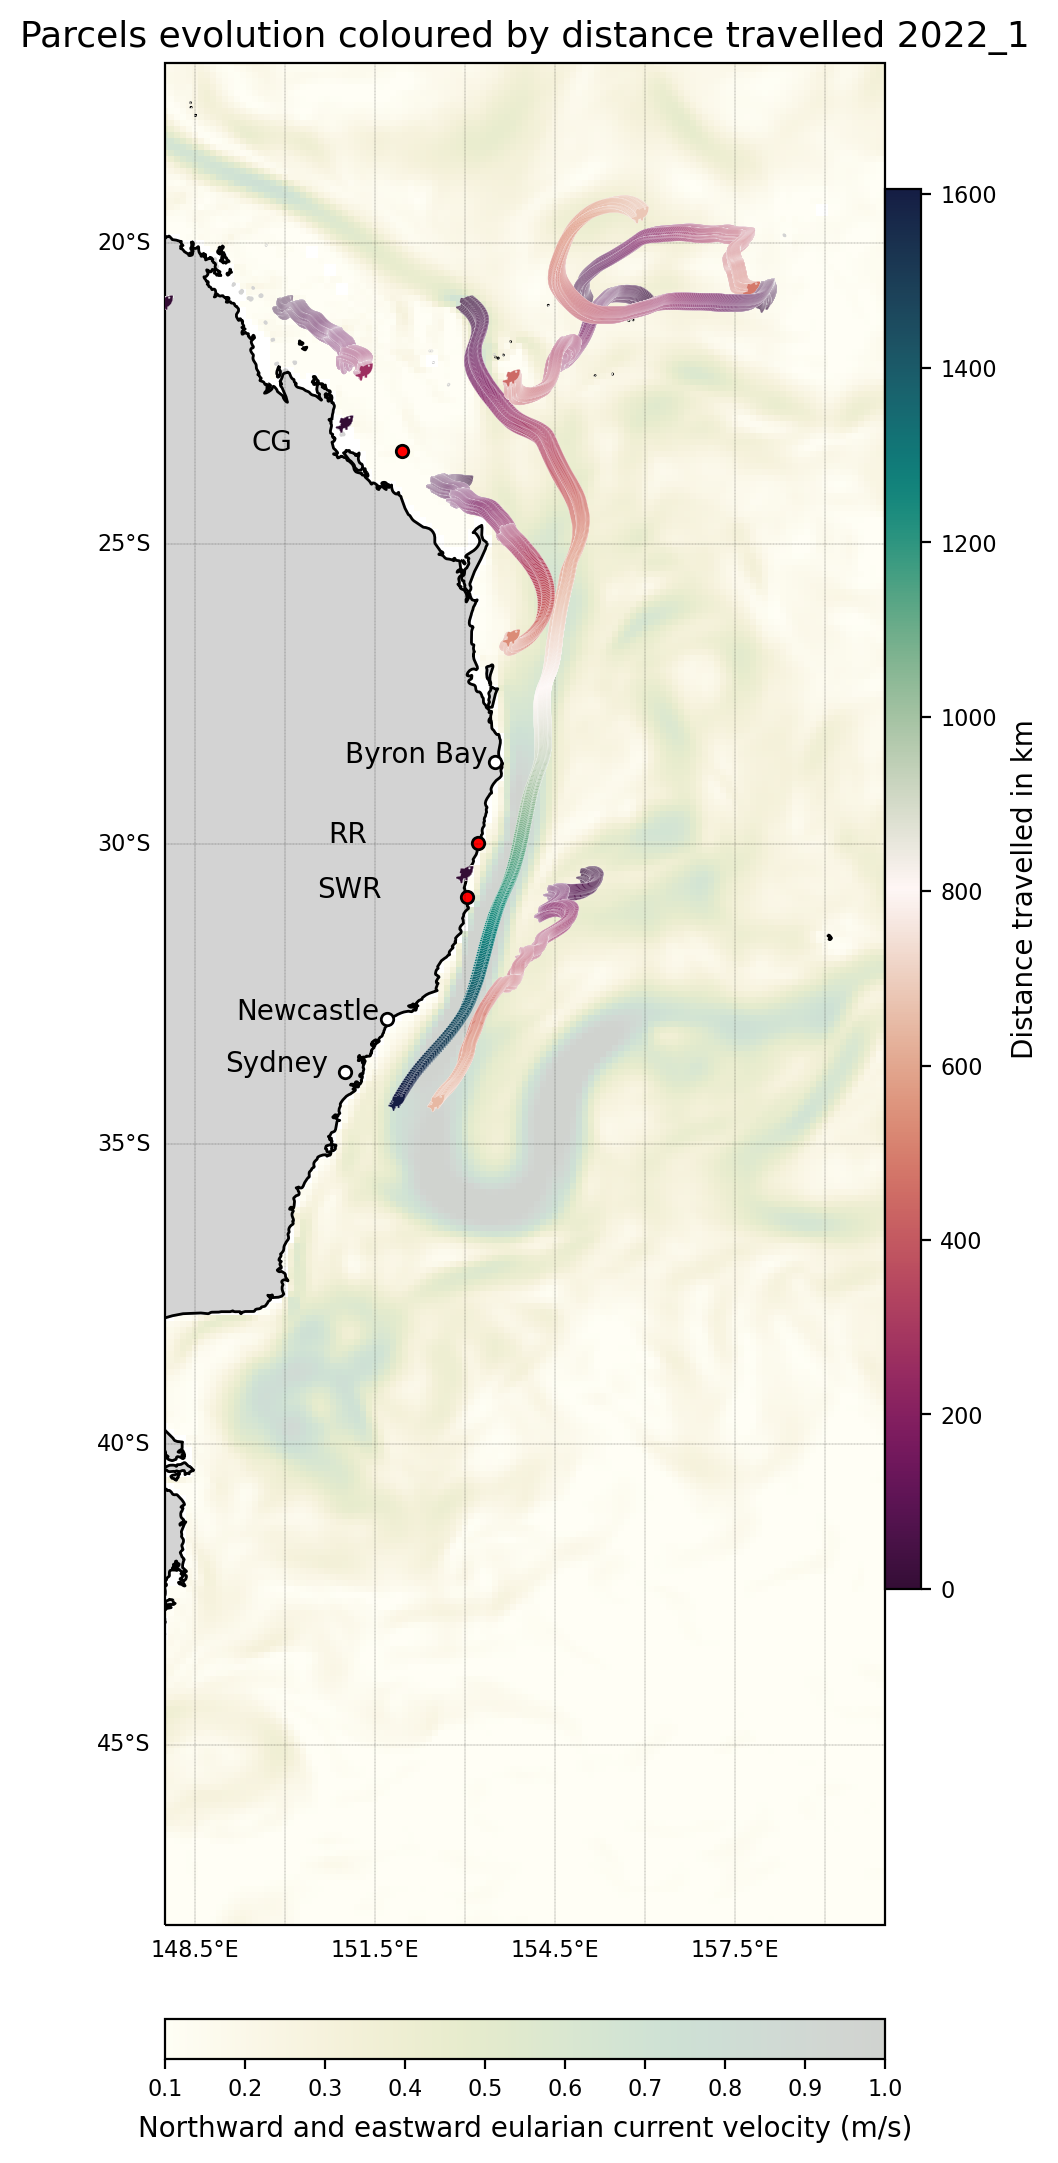

<Figure size 640x480 with 0 Axes>

In [20]:
# Figure size
size = (9, 10)

# Color from cmocean
color = cmocean.cm.speed

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())


# Plotting mean current 
cf = ds_hydro.speed.mean('Time').plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0.1, vmax = 1.0, alpha=0.2, 
    add_colorbar=False
)

# Title
plt.title('Parcels evolution coloured by distance travelled '+str(year)+'_'+str(month),
          fontsize=13
         )

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

# # Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

distmin = parcels_dist.distance.min().item()
distmax = parcels_dist.distance.max().item()

fish_marker.vertices -= fish_marker.vertices.mean(axis=0)
fish_marker = fish_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
fish_marker = fish_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))

for k in range(parcels_dist.lon.shape[0]):
    sc = plt.scatter(parcels_dist.lon.isel(trajectory=k), parcels_dist.lat.isel(trajectory=k), marker = fish_marker, s=45, 
               c=parcels_dist.distance.isel(trajectory=k), edgecolors='w', 
               cmap='cmo.curl_r', vmin=distmin, vmax=distmax, 
               linewidth=0.1, transform=ccrs.PlateCarree()).set_zorder(11)
    

# # Color bar

# Adding the colorbar
cbaxes2 = fig.add_axes([0.7, 0.2, 0.02, 0.7]) 
cbar2 = plt.colorbar(sc, cax=cbaxes2) #, fraction=0.027, pad=0.045)
cbar2.set_label('Distance travelled in km', rotation=90, 
               labelpad=5, fontsize=10)
cbar2.ax.tick_params(labelsize=8)

cbaxes = fig.add_axes([0.3, -0.035, 0.4, 0.02]) 
cbar = fig.colorbar(cf, cax=cbaxes, orientation="horizontal") #ax=ax, fraction=0.027, pad=0.045, 
#                     orientation="horizontal")

cbar.set_label('Northward and eastward eularian current velocity (m/s)', rotation=0, 
               labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Sydney dot
syd_lat = -33.8
syd_lon = 151
ax.scatter(syd_lon, syd_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
           transform=ccrs.PlateCarree())
ax.plot(syd_lon, syd_lat, transform=ccrs.Geodetic())
ax.text(syd_lon-2, syd_lat, 'Sydney', transform=ccrs.Geodetic())


#Newcastle plot
newc_lat = -32.92
newc_lon = 151.70
ax.scatter(newc_lon, newc_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(newc_lon, newc_lat, transform=ccrs.Geodetic())
ax.text(newc_lon-2.5, newc_lat, 'Newcastle', transform=ccrs.Geodetic())

#Byron Bay Plot
bbay_lat = -28.64
bbay_lon = 153.50
ax.scatter(bbay_lon, bbay_lat, c='white', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-2.5, bbay_lat, 'Byron Bay', transform=ccrs.Geodetic())

#Capricorn Group Plot
bbay_lat = -23.45
bbay_lon = 151.95
ax.scatter(bbay_lon, bbay_lat, c='red', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-2.5, bbay_lat, 'CG', transform=ccrs.Geodetic())

#Red Rocks Plot
bbay_lat = -29.98
bbay_lon = 153.22
ax.scatter(bbay_lon, bbay_lat, c='red', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-2.5, bbay_lat, 'RR', transform=ccrs.Geodetic())

#South West Rocks Plot
bbay_lat = -30.89
bbay_lon = 153.04
ax.scatter(bbay_lon, bbay_lat, c='red', zorder=2, s=20, edgecolors='k', linewidth=1,
            transform=ccrs.PlateCarree())
ax.plot(bbay_lon, bbay_lat, transform=ccrs.Geodetic())
ax.text(bbay_lon-2.5, bbay_lat, 'SWR', transform=ccrs.Geodetic())

plt.tight_layout()
#plt.savefig('Particle'+str(year)+'_'+str(month)+'.png',dpi=300)
plt.show()
fig.clear()
plt.close(fig)
plt.clf()


End.